# Fairness Mitigation in Machine Learning

This notebook demonstrates two bias mitigation strategies:
-  **Pre-processing**: Reweighing
-  **Post-processing**: Equalized Odds Postprocessing

We evaluate their impact using fairness and performance metrics.


**Install Librairies**

In [53]:
!pip install datasets
!pip install optuna
!pip install tensorflow
!pip install fairlearn
!pip install aif360

**Loading Librairies**

In [54]:
import warnings
warnings.filterwarnings("ignore")
from datasets import load_dataset
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import auc, roc_curve, precision_score, recall_score, precision_recall_curve,log_loss
import optuna
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
print("Setup Complete")

Setup Complete


**Load our dataset**

In [55]:
ds = load_dataset("criteo/FairJob")
df = ds['train'].to_pandas()

**Useful functions**

In [56]:
def print_results(X_test, y_test, model):
    # Calcul des probabilités des prédictions
    y_scores = model.predict_proba(X_test)[:, 1]  # Probabilité d'être classe 1

    # Calcul des courbes précision-rappel
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Calcul du F1-score pour chaque seuil
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Évite division par zéro

    # Trouver l'index du meilleur F1-score
    best_threshold_index = np.argmax(f1_scores)

    # Le tableau "thresholds" est plus court d'un élément → il faut ajuster l'indexation
    if best_threshold_index == 0:  # Si le max est au début, on prend le premier seuil
        best_threshold = thresholds[0]
    else:
        best_threshold = thresholds[best_threshold_index - 1]

    # Précision et rappel au meilleur seuil
    precision_optimal = precisions[best_threshold_index]
    recall_optimal = recalls[best_threshold_index]
    f1_score_optimal = f1_scores[best_threshold_index]

    # Calcul du log loss
    log_loss_value = log_loss(y_test, y_scores)

    print(f'Best Threshold: {best_threshold}')
    print(f'\nPrecision at Best Threshold: {precision_optimal}')
    print(f'Recall at Best Threshold: {recall_optimal}')
    print(f'F1 Score at Best Threshold: {f1_score_optimal}')
    print(f'Log Loss: {log_loss_value}')

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[1:], label='Précision', color='blue')
    plt.plot(thresholds, recalls[1:], label='Recall', color='red')
    plt.axvline(x=best_threshold, color='green', linestyle='--', label="Seuil Optimal")
    plt.xlabel("Seuil de classification")
    plt.ylabel("Score")
    plt.title("Courbe Précision-Recall en fonction du seuil")
    plt.legend()
    plt.grid()
    plt.show()

In [57]:
def evaluate_log_loss_by_class(y_true, y_proba):
    """
    Calcule la log loss globale, la log loss par classe, et la confiance moyenne sur les vrais positifs.
    
    Parameters
    ----------
    y_true : array-like
        Vecteur des vraies étiquettes (0 ou 1)
    y_proba : array-like, shape (n_samples, 2)
        Probabilités prédites (sorties de predict_proba)

    Returns
    -------
    dict with:
        - 'log_loss_global'
        - 'log_loss_y0'
        - 'log_loss_y1'
        - 'mean_proba_y1' (moyenne des p(y=1) quand y=1)
    """
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    return {
        "log_loss_global": round(log_loss(y_true, y_proba), 5),
        "log_loss_y0": round(log_loss(y_true[y_true == 0], y_proba[y_true == 0], labels=[0, 1]), 5),
        "log_loss_y1": round(log_loss(y_true[y_true == 1], y_proba[y_true == 1], labels=[0, 1]), 5),
        "mean_proba_y1": round(float(y_proba[y_true == 1, 1].mean()), 5)
        }



**Spliting our dataset**

In [59]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['click','user_id','impression_id','product_id'])
y = df['click']

X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)

**Training our selected Xgboost model**

In [62]:

# Define preprocess + pipeline

cat_cols_bin = list(X_train.columns[0:3])
rank_col = ['rank']
cat_cols = list(X_train.columns[4:17])

data_preproc = ColumnTransformer([('multicat_encoding', TargetEncoder(target_type='binary'), cat_cols)], 
                              remainder='passthrough', force_int_remainder_cols=False)

xgb_pipe = Pipeline([('preprocessing', data_preproc),
                     ('xgb',XGBClassifier())])

# Set params

scale_pos_weight = (
        (np.sum(y_train < 1) / np.sum(y_train > 0))
    )

params = {
    'xgb__max_depth': 9, 
    'xgb__min_child_weight': 0.0001571124384178228, 
    'xgb__subsample': 0.7648038086116782, 
    'xgb__learning_rate': 0.00497357053166194, 
    'xgb__colsample_bytree': 0.7245817577957009, 
    'xgb__reg_lambda': 0.4999935268511382, 
    'xgb__gamma': 2.0806419432420054, 
    'xgb__base_score': 0.7790489714094901,
    'xgb__scale_pos_weight' : scale_pos_weight
    }

xgb_pipe.set_params(**params)
xgb_pipe.fit(X_train, y_train)
prob = xgb_pipe.predict_proba(X_test)

**Model performance**

Best Threshold: 0.8041020631790161

Precision at Best Threshold: 0.10393498716852011
Recall at Best Threshold: 0.16221628838451269
F1 Score at Best Threshold: 0.12669447293377756
Log Loss: 0.8864411774640928


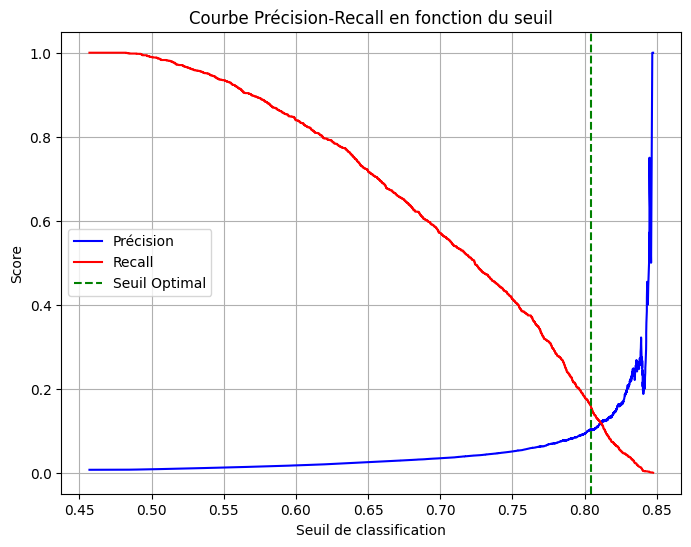

In [64]:
model = xgb_pipe.named_steps['xgb']
print_results(X_test, y_test, xgb_pipe)

**Others metrics**

In [65]:
from functions import report_results

best_threshold = 0.8041020631790161


y_pred_proba = pd.Series(prob[:, 1], index=X_test.index)
y_pred = (y_pred_proba > best_threshold).astype(int)
report_results(df, y_pred_proba, y_pred)

{'Click Rank Utility': np.float64(0.00914),
 'Negative Log-Likelihood': np.float64(0.88644),
 'AUC': np.float64(0.84104),
 'Demographic Parity': np.float64(-0.00416)}

**Fairness metrics**

In [67]:
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import equalized_odds_difference

positive_rate_0= np.mean(y_pred[X_test['protected_attribute'] == 0])
positive_rate_1= np.mean(y_pred[X_test['protected_attribute'] == 1])


metrics = {
    'demographic_parity': demographic_parity_difference(
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=X_test['protected_attribute']
    ),
    'equalized_odds': equalized_odds_difference(
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=X_test['protected_attribute']
    ),
    'disparate impact': positive_rate_1/positive_rate_0

}

metrics

{'demographic_parity': np.float64(0.0032430784881192047),
 'equalized_odds': 0.07325913242009131,
 'disparate impact': np.float64(0.7410194308821653)}

**Feature importance**

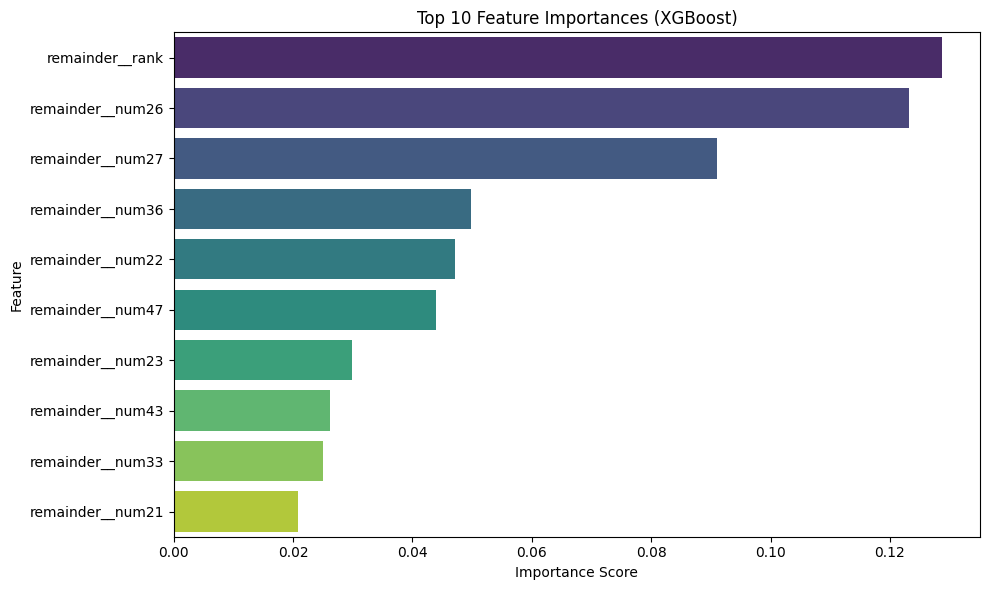

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Access fitted XGBoost model
xgb_model = xgb_pipe.named_steps['xgb']

# 2. Get feature names after preprocessing
# Fit the preprocessor alone to get transformed feature names
data_preproc.fit(X_train, y_train)

try:
    feature_names = data_preproc.get_feature_names_out()
except AttributeError:
    # Some versions of sklearn <1.0 use this alternative
    feature_names = data_preproc.get_feature_names()

# 3. Get feature importances
importances = xgb_model.feature_importances_

# 4. Create DataFrame and sort
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# 5. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


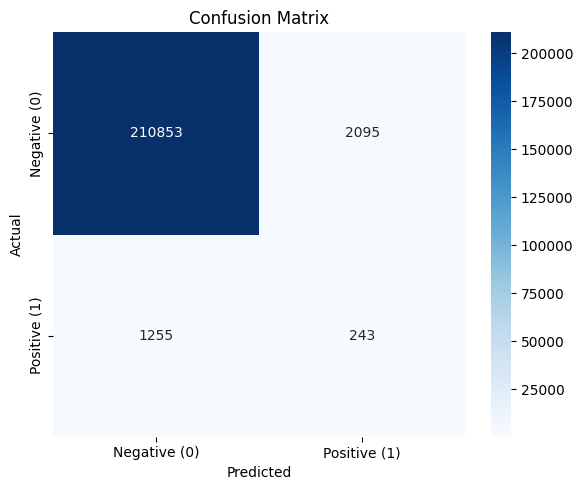

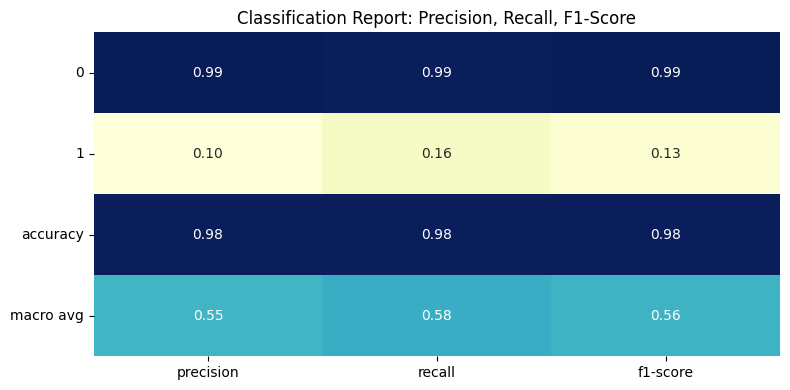

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 2. Classification Report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Round for readability
report_df = report_df.round(3)

# 3. Display table (optional: style it if in notebook or save to file)
plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt='.2f', cmap='YlGnBu', cbar=False)
plt.title('Classification Report: Precision, Recall, F1-Score')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


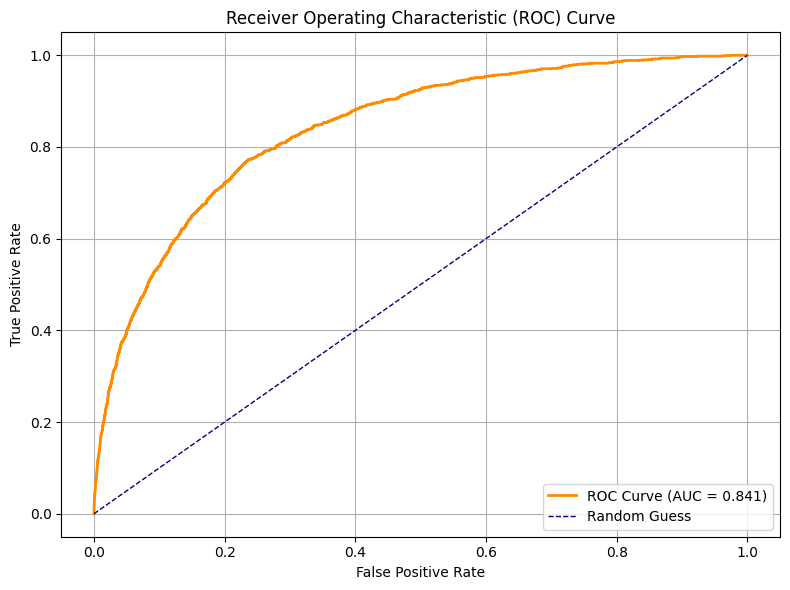

In [70]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Get predicted probabilities for the positive class
y_proba = xgb_pipe.predict_proba(X_test)[:, 1]

# 2. Calculate FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 3. AUC score
roc_auc = roc_auc_score(y_test, y_proba)

# 4. Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**Evaluate the proportion of Click prediction**

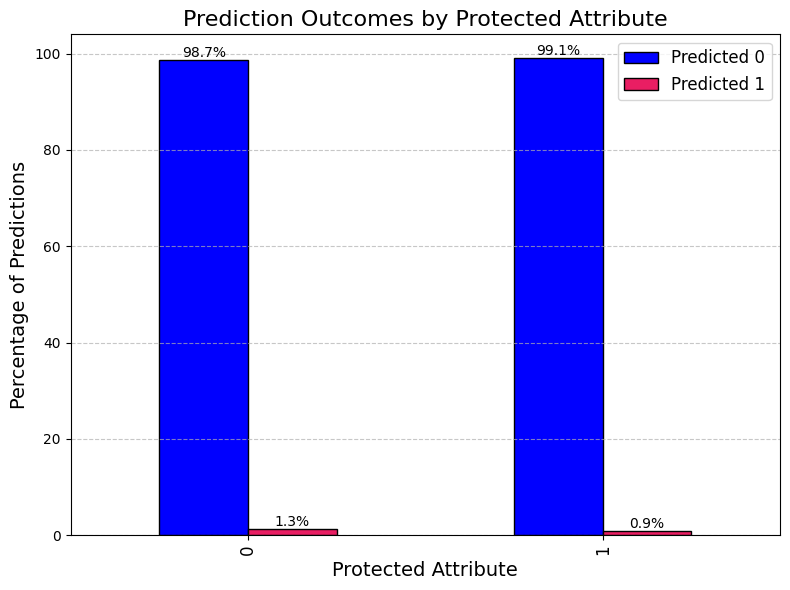

In [71]:
# Create the DataFrame
df_pred = pd.DataFrame({
    'protected_attribute': X_test['protected_attribute'],
    'y_pred': y_pred
})

# Group by protected_attribute and prediction
grouped = df_pred.groupby(['protected_attribute', 'y_pred']).size().unstack(fill_value=0)

# Calculate percentages
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot only unstacked percentage bars
custom_colors = ['blue', '#e91e63']  # Blue and Pink

ax = percentages.plot(kind='bar', stacked=False, figsize=(8, 6), color=custom_colors, edgecolor='black')

ax.set_title('Prediction Outcomes by Protected Attribute', fontsize=16)
ax.set_xlabel('Protected Attribute', fontsize=14)
ax.set_ylabel('Percentage of Predictions', fontsize=14)
ax.set_xticks([0, 1])
ax.set_xticklabels(['0', '1'], fontsize=12)
ax.legend(['Predicted 0', 'Predicted 1'], fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentages on top
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

plt.tight_layout()
plt.show()


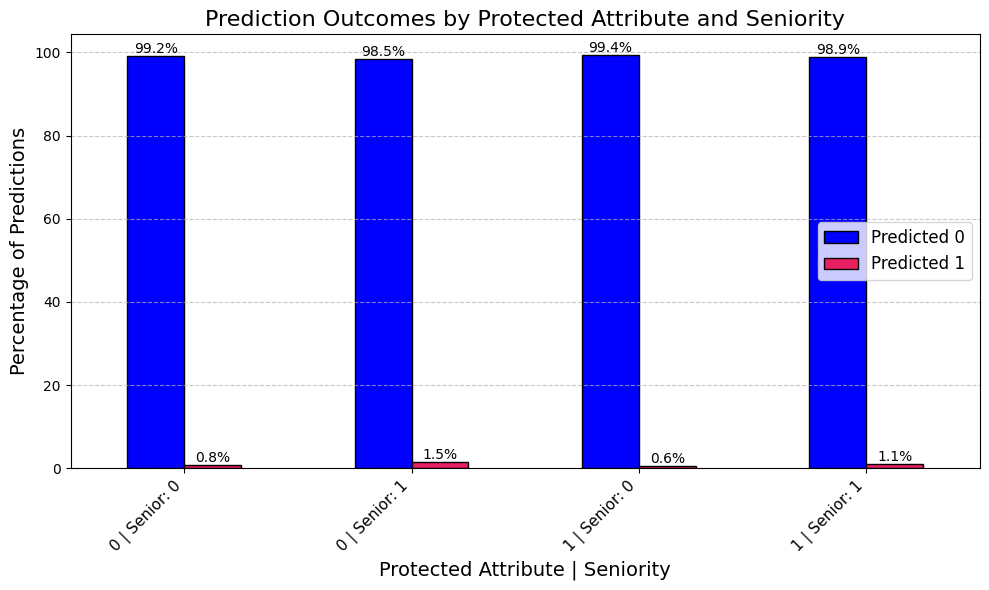

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame with seniority
df_pred = pd.DataFrame({
    'protected_attribute': X_test['protected_attribute'],
    'senior': X_test['senior'],
    'y_pred': y_pred
})

# Group by protected_attribute, senior, and prediction
grouped = df_pred.groupby(['protected_attribute', 'senior', 'y_pred']).size().unstack(fill_value=0)

# Calculate percentages within each (protected_attribute, senior) group
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Reset index for plotting
percentages = percentages.reset_index()

# Create a combined label for x-axis
percentages['Group'] = percentages['protected_attribute'].astype(str) + ' | Senior: ' + percentages['senior'].astype(str)

# Plotting
custom_colors = ['blue', '#e91e63']  # Predicted 0 = Blue, Predicted 1 = Pink

ax = percentages[[0, 1]].plot(
    kind='bar', 
    stacked=False, 
    figsize=(10, 6), 
    color=custom_colors, 
    edgecolor='black'
)

# Custom x-axis labels
ax.set_xticks(range(len(percentages)))
ax.set_xticklabels(percentages['Group'], rotation=45, ha='right', fontsize=11)

ax.set_title('Prediction Outcomes by Protected Attribute and Seniority', fontsize=16)
ax.set_xlabel('Protected Attribute | Seniority', fontsize=14)
ax.set_ylabel('Percentage of Predictions', fontsize=14)
ax.legend(['Predicted 0', 'Predicted 1'], fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentages on top
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

plt.tight_layout()
plt.show()


**Post processing Method**

In [73]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.metrics import ClassificationMetric
import warnings
warnings.filterwarnings("ignore")


# ----------------------------------
# 1. Prepare test set predictions
# ----------------------------------

best_threshold = 0.8035001158714294
prob = xgb_pipe.predict_proba(X_test)

y_pred_proba = pd.Series(prob[:, 1], index=X_test.index)
y_pred = (y_pred_proba > best_threshold).astype(int)

X_test_copy = X_test.copy()
X_test_copy['label'] = y_test
X_test_copy['protected'] = X_test['protected_attribute']  # Ensure binary (0/1)

# ----------------------------------
# 2. Convert to AIF360 format
# ----------------------------------
test_aif = BinaryLabelDataset(
    df=X_test_copy,
    label_names=['label'],
    protected_attribute_names=['protected']
)

test_pred_aif = test_aif.copy()
test_pred_aif.labels = y_pred.to_numpy().reshape(-1, 1)

# ----------------------------------
# 3. Define privileged/unprivileged groups
# ----------------------------------
privileged_groups = [{'protected': 1}]
unprivileged_groups = [{'protected': 0}]

# ----------------------------------
# 4. Postprocessing: Equalized Odds
# ----------------------------------
eq_odds = EqOddsPostprocessing(
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
    seed=42
)

eq_odds.fit(test_aif, test_pred_aif)
pred_transformed = eq_odds.predict(test_pred_aif)
y_pred_post = pred_transformed.labels.ravel()

In [74]:
# ----------------------------------
# 5. Define evaluation function
# ----------------------------------
def evaluate_fairness_and_performance(y_test, y_pred, y_pred_post,
                                      test_aif, test_pred_aif, pred_transformed,
                                      privileged_groups, unprivileged_groups):
    metric_before = ClassificationMetric(test_aif, test_pred_aif,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
    metric_after = ClassificationMetric(test_aif, pred_transformed,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)

    metrics = {
        "Accuracy": [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_post)],
        "F1 Score": [f1_score(y_test, y_pred), f1_score(y_test, y_pred_post)],
        "Precision": [precision_score(y_test, y_pred), precision_score(y_test, y_pred_post)],
        "Recall": [recall_score(y_test, y_pred), recall_score(y_test, y_pred_post)],
        "Log Loss": [log_loss(y_test, y_pred), log_loss(y_test, y_pred_post)],
        "Equal Opportunity Diff": [metric_before.equal_opportunity_difference(), metric_after.equal_opportunity_difference()],
        "Average Odds Diff": [metric_before.average_odds_difference(), metric_after.average_odds_difference()],
        "Demographic Parity Diff": [metric_before.statistical_parity_difference(), metric_after.statistical_parity_difference()],
    }

    return pd.DataFrame(metrics, index=["Before Postprocessing", "After Postprocessing"]).T


# ----------------------------------
# 6. Get and display results table
# ----------------------------------
results_table = evaluate_fairness_and_performance(
    y_test, y_pred, y_pred_post,
    test_aif, test_pred_aif, pred_transformed,
    privileged_groups, unprivileged_groups
)

print("\n=== Evaluation Table ===")
print(results_table)



=== Evaluation Table ===
                         Before Postprocessing  After Postprocessing
Accuracy                              0.984005              0.985152
F1 Score                              0.125446              0.108623
Precision                             0.101485              0.093539
Recall                                0.164219              0.129506
Log Loss                              0.576508              0.535160
Equal Opportunity Diff                0.069150              0.001441
Average Odds Diff                     0.035966              0.000714
Demographic Parity Diff               0.003298              0.000037


Click rank utility before and after post processing

In [75]:
from functions import click_rank_utility
print('After:',click_rank_utility(df,pd.Series(y_pred_post, index=X_test.index)))
print('Before:',click_rank_utility(df,y_pred))

After: 0.009113900488815512
Before: 0.009113900488815512


In [76]:
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import equalized_odds_difference


metrics = {
    'demographic_parity': demographic_parity_difference(
        y_true=y_test,
        y_pred=y_pred_post,
        sensitive_features=X_test['protected_attribute']
    ),
    'equalized_odds': equalized_odds_difference(
        y_true=y_test,
        y_pred=y_pred_post,
        sensitive_features=X_test['protected_attribute']
    )

}

metrics

{'demographic_parity': np.float64(3.719673769300019e-05),
 'equalized_odds': 0.0014412100456621113}

Fairness vs Performance

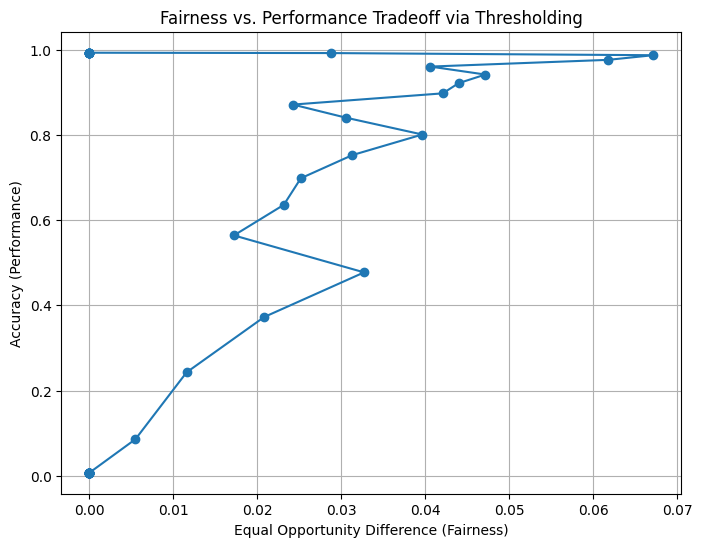

In [77]:
thresholds = np.linspace(0.01, 0.99, 50)
acc_list = []
eo_diff_list = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba > thresh).astype(int)

    test_pred_aif_thresh = test_aif.copy()
    test_pred_aif_thresh.labels = y_pred_thresh.to_numpy().reshape(-1, 1)

    metric = ClassificationMetric(
        test_aif,
        test_pred_aif_thresh,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    acc = accuracy_score(y_test, y_pred_thresh)
    eo_diff = abs(metric.equal_opportunity_difference())

    acc_list.append(acc)
    eo_diff_list.append(eo_diff)

# Plot the tradeoff
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(eo_diff_list, acc_list, marker='o')
plt.xlabel('Equal Opportunity Difference (Fairness)')
plt.ylabel('Accuracy (Performance)')
plt.title('Fairness vs. Performance Tradeoff via Thresholding')
plt.grid(True)
plt.show()


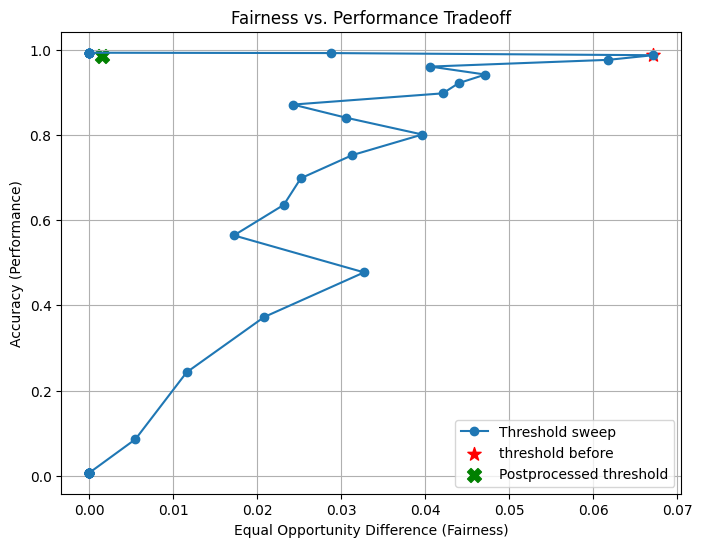

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from aif360.metrics import ClassificationMetric

# Define thresholds to sweep
thresholds = np.linspace(0.01, 0.99, 50)
acc_list = []
eo_diff_list = []

# Sweep thresholds and collect performance/fairness
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba > thresh).astype(int)

    test_pred_aif_thresh = test_aif.copy()
    test_pred_aif_thresh.labels = y_pred_thresh.to_numpy().reshape(-1, 1)

    metric = ClassificationMetric(
        test_aif,
        test_pred_aif_thresh,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    acc = accuracy_score(y_test, y_pred_thresh)
    eo_diff = abs(metric.equal_opportunity_difference())

    acc_list.append(acc)
    eo_diff_list.append(eo_diff)

# === Highlight selected threshold BEFORE postprocessing ===
closest_idx = (np.abs(thresholds - best_threshold)).argmin()
best_acc = acc_list[closest_idx]
best_eo_diff = eo_diff_list[closest_idx]

# === Compute postprocessed results ===
# Already computed earlier:
# eq_odds.fit(test_aif, test_pred_aif)
# pred_transformed = eq_odds.predict(test_pred_aif)
y_pred_post = pred_transformed.labels.ravel()
acc_post = accuracy_score(y_test, y_pred_post)

metric_post = ClassificationMetric(
    test_aif,
    pred_transformed,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
eo_diff_post = abs(metric_post.equal_opportunity_difference())

# === Plotting ===
plt.figure(figsize=(8, 6))
plt.plot(eo_diff_list, acc_list, marker='o', label='Threshold sweep')

# Highlight selected threshold
plt.scatter(best_eo_diff, best_acc, color='red', s=100, marker='*', label=f'threshold before')

# Highlight postprocessed point
plt.scatter(eo_diff_post, acc_post, color='green', s=100, marker='X', label='Postprocessed threshold')

plt.xlabel('Equal Opportunity Difference (Fairness)')
plt.ylabel('Accuracy (Performance)')
plt.title('Fairness vs. Performance Tradeoff')
plt.legend()
plt.grid(True)
plt.show()


Others metrics after reweighting

In [79]:
from functions import report_results

best_threshold_post = best_eo_diff

y_pred_proba = pd.Series(prob[:, 1], index=X_test.index)
y_pred_post = (y_pred_proba > best_threshold_post).astype(int)
report_results(df, y_pred_proba, y_pred_post)

{'Click Rank Utility': np.float64(0.00894),
 'Negative Log-Likelihood': np.float64(0.88644),
 'AUC': np.float64(0.84104),
 'Demographic Parity': np.float64(0.0)}

On other fairness metrics

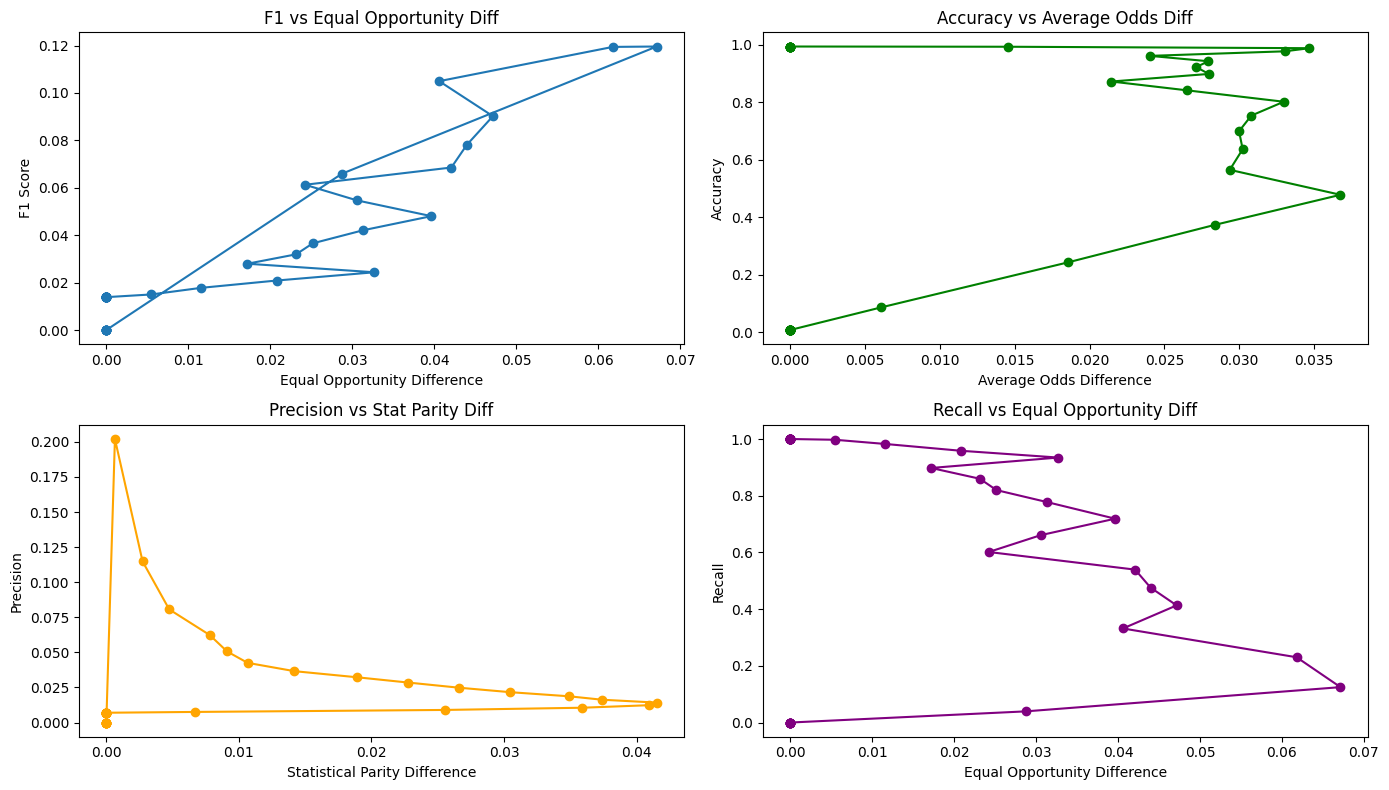

In [80]:
import matplotlib.pyplot as plt

# Define thresholds to evaluate
thresholds = np.linspace(0.01, 0.99, 50)

# Store results
results = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba > threshold).astype(int)

    # Convert prediction to AIF360 format
    test_pred_thresh = test_aif.copy()
    test_pred_thresh.labels = y_pred_thresh.to_numpy().reshape(-1, 1)

    # Fairness metric before postprocessing
    metric = ClassificationMetric(
        test_aif,
        test_pred_thresh,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    # Collect metrics
    results.append({
        'threshold': threshold,
        'accuracy': accuracy_score(y_test, y_pred_thresh),
        'f1': f1_score(y_test, y_pred_thresh),
        'precision': precision_score(y_test, y_pred_thresh),
        'recall': recall_score(y_test, y_pred_thresh),
        'log_loss': log_loss(y_test, y_pred_thresh),
        'eq_opp_diff': metric.equal_opportunity_difference(),
        'avg_odds_diff': metric.average_odds_difference(),
        'stat_parity_diff': metric.statistical_parity_difference()
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plot: Utility vs Fairness
plt.figure(figsize=(14, 8))

# Example: F1-score vs Equal Opportunity Diff
plt.subplot(2, 2, 1)
plt.plot(results_df['eq_opp_diff'], results_df['f1'], marker='o')
plt.xlabel('Equal Opportunity Difference')
plt.ylabel('F1 Score')
plt.title('F1 vs Equal Opportunity Diff')

# Accuracy vs Average Odds Diff
plt.subplot(2, 2, 2)
plt.plot(results_df['avg_odds_diff'], results_df['accuracy'], marker='o', color='green')
plt.xlabel('Average Odds Difference')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Average Odds Diff')

# Precision vs Statistical Parity Diff
plt.subplot(2, 2, 3)
plt.plot(results_df['stat_parity_diff'], results_df['precision'], marker='o', color='orange')
plt.xlabel('Statistical Parity Difference')
plt.ylabel('Precision')
plt.title('Precision vs Stat Parity Diff')

# Recall vs Equal Opportunity Diff
plt.subplot(2, 2, 4)
plt.plot(results_df['eq_opp_diff'], results_df['recall'], marker='o', color='purple')
plt.xlabel('Equal Opportunity Difference')
plt.ylabel('Recall')
plt.title('Recall vs Equal Opportunity Diff')

plt.tight_layout()
plt.show()

**Reweight**

Useful functions for reweighting 

In [50]:
import pandas as pd
import numpy as np
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import optuna



# Assuming your features are in a DataFrame and y in a Series
def create_aif_dataset(X, y, protected_attr):
    df = X.copy()
    df['label'] = y
    df[protected_attr] = X[protected_attr]  # Ensure sensitive attribute is present

    dataset = StandardDataset(
        df,
        label_name='label',
        favorable_classes=[1],
        protected_attribute_names=[protected_attr],
        privileged_classes=[[1]],  # Adjust depending on your context
    )
    return dataset

# Reweighing function
def apply_reweighing(X, y, protected_attr):
    if isinstance(X, np.ndarray):
        raise ValueError("X must be a pandas DataFrame with column names.")

    dataset = create_aif_dataset(X, y, protected_attr)
    rw = Reweighing(unprivileged_groups=[{protected_attr: 0}],
                    privileged_groups=[{protected_attr: 1}])
    dataset_rw = rw.fit_transform(dataset)

    instance_weights = dataset_rw.instance_weights
    X_rw = pd.DataFrame(dataset_rw.features, columns=X.columns)  # <-- convert to DataFrame
    y_rw = dataset_rw.labels.ravel()
    return X_rw, y_rw, instance_weights


# Now redefine the Optuna objective
def objective_scale(trial):
    X_train_train, X_val, y_train_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train
    )

    # Apply reweighing
    X_rw, y_rw, instance_weights = apply_reweighing(X_train_train, y_train_train, protected_attr='protected_attribute')  # Replace 'protected_attribute' with your actual column name

    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_float("min_child_weight", 0.0001, 100, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0.1, 10, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 100, log=True)
    base_score = trial.suggest_float("base_score", 1e-4, 1 - 1e-4)

    scale_pos_weight = (np.sum(y_rw < 1) / np.sum(y_rw > 0))

    xgb_params = {
        'xgb__max_depth': max_depth,
        'xgb__min_child_weight': min_child_weight,
        'xgb__subsample': subsample,
        'xgb__learning_rate': learning_rate,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__reg_lambda': reg_lambda,
        'xgb__gamma': gamma,
        'xgb__base_score': base_score,
        'xgb__scale_pos_weight': scale_pos_weight,
    }

    xgb_pipe.set_params(**xgb_params)
    xgb_pipe.fit(X_rw, y_rw, xgb__sample_weight=instance_weights)

    prob_val = xgb_pipe.predict_proba(X_val)
    return log_loss(y_val, prob_val)


In [51]:
# Define preprocess + pipeline

cat_cols_bin = list(X_train.columns[0:3])
rank_col = ['rank']
cat_cols = list(X_train.columns[4:17])

data_preproc = ColumnTransformer([('multicat_encoding', TargetEncoder(target_type='binary'), cat_cols)], 
                              remainder='passthrough', force_int_remainder_cols=False)

X_rw_full, y_rw_full, instance_weights_full = apply_reweighing(X_train, y_train, protected_attr='protected_attribute')


Reweight and Tune model

In [ ]:
xgb_pipe_rt = Pipeline([('preprocessing', data_preproc),
                     ('xgb',XGBClassifier())])


# Run Optuna study
n_trials = 100
study = optuna.create_study(direction="minimize")
study.optimize(objective_scale, n_trials=n_trials)
optimal_trial = study.best_trial

print("\nOptimization done")

# Retrain on full reweighted training set
X_rw_full, y_rw_full, instance_weights_full = apply_reweighing(X_train, y_train, protected_attr='protected_attribute')

xgb_tuned_params_rt = {
    'xgb__max_depth': optimal_trial.params["max_depth"],
    'xgb__min_child_weight': optimal_trial.params["min_child_weight"],
    'xgb__gamma': optimal_trial.params["gamma"],
    'xgb__subsample': optimal_trial.params["subsample"],
    'xgb__learning_rate': optimal_trial.params["learning_rate"],
    'xgb__colsample_bytree': optimal_trial.params["colsample_bytree"],
    'xgb__reg_lambda': optimal_trial.params["reg_lambda"],
    'xgb__base_score': optimal_trial.params["base_score"],
    'xgb__scale_pos_weight': (np.sum(y_rw_full < 1) / np.sum(y_rw_full > 0)),
}

print("\ntuned with reweighting completed.")

In [ ]:
xgb_pipe_rt.set_params(**xgb_tuned_params_rt)
xgb_pipe_rt.fit(X_rw_full, y_rw_full, xgb__sample_weight=instance_weights_full)

print("\nTraining with reweighting completed.")

# Final evaluation
xgb_adapted_scale_tuned = evaluate_log_loss_by_class(y_test, xgb_pipe_rt.predict_proba(X_test))

xgb_adapted_scale_tuned


Training with reweighting completed.


{'log_loss_global': 0.06256,
 'log_loss_y0': 0.03261,
 'log_loss_y1': 4.32005,
 'mean_proba_y1': 0.14336}

Model performance

Best Threshold: 0.45238062739372253

Precision at Best Threshold: 0.06740370898716119
Recall at Best Threshold: 0.1261682242990654
F1 Score at Best Threshold: 0.0878661083326912
Log Loss: 0.06255983095305756


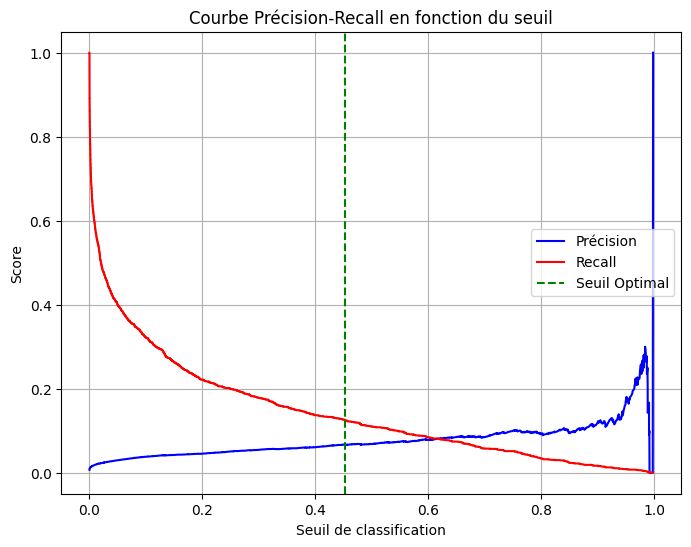

In [ ]:

print_results(X_test, y_test, xgb_pipe_rt)


In [ ]:
prob_rt = xgb_pipe_rt.predict_proba(X_test)
best_threshold_rt = 0.45238062739372253

y_pred_proba_rt = pd.Series(prob_rt[:, 1], index=X_test.index)
y_pred_rt = (y_pred_proba_rt > best_threshold_rt).astype(int)
report_results(df, y_pred_proba_rt, y_pred_rt)

{'Click Rank Utility': np.float64(0.00916),
 'Negative Log-Likelihood': np.float64(0.06256),
 'AUC': np.float64(0.74852),
 'Demographic Parity': np.float64(-0.0021)}

Fairness metrics for the reweight and tuned model

In [ ]:
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import equalized_odds_difference

positive_rate_0_rt= np.mean(y_pred_rt[X_test['protected_attribute'] == 0])
positive_rate_1_rt= np.mean(y_pred_rt[X_test['protected_attribute'] == 1])


metrics_rt = {
    'demographic_parity': demographic_parity_difference(
        y_true=y_test,
        y_pred=y_pred_rt,
        sensitive_features=X_test['protected_attribute']
    ),
    'equalized_odds': equalized_odds_difference(
        y_true=y_test,
        y_pred=y_pred_rt,
        sensitive_features=X_test['protected_attribute']
    ),
    'disparate impact': positive_rate_1_rt/positive_rate_0_rt

}

metrics_rt

{'demographic_parity': np.float64(0.00161607535727659),
 'equalized_odds': 0.043025827625570764,
 'disparate impact': np.float64(0.8835915974023996)}